In [83]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns 
import cvxpy as cvx

In [112]:
def generate_model_params(top_species, resources, C_mean, C_std_dev, rho):
    zero_mean_c = C_std_dev * np.random.normal(0, 1, (top_species, resources)) / np.sqrt(resources)
    C = C_mean/resources + zero_mean_c
    E = generate_E(C_mean, top_species, resources, rho, zero_mean_c)
    u = np.random.uniform(0.5, 1.5, top_species)
    k = np.ones(resources) * 10
    return C, E, u, k

def generate_E(E_mean, top_species, resources, rho, zero_mean_c ):
    zero_mean_d = C_std_dev * np.random.normal(0, 1, (top_species, resources)) / np.sqrt(resources)
    return E_mean/resources + rho * zero_mean_c   + np.sqrt(1 - rho**2) * zero_mean_d

def asymmetric_consumer_resource(t, state, top_species, C, u, migration, E, k):
    X = state[:top_species]
    R = state[top_species:]

    dX = X * (np.dot(C, R) - u) + migration
    dR = R * (k - R - np.dot(E.T, X)) + migration

    return np.concatenate((dX, dR), axis=None)

def consumer_resource(t, state, top_species, C, u, k):
    X = state[:top_species]
    R = state[top_species:]

    dX = X * (np.dot(C, R) - u)
    dR = R * (k - R - np.dot(C.T, X))

    return np.concatenate((dX, dR), axis=None)

def ODE_simulator(model_type, t_span, initial_state, top_species, resources, C, E, u, k, migration):
    if model_type == 'asymmetric_consumer_resource':
        ode_function = lambda t, state: asymmetric_consumer_resource(t, state, top_species, C, u, migration, E, k)
    elif model_type == 'consumer_resource':
        ode_function = lambda t, state: consumer_resource(t, state, top_species, C, u, k)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    sol = solve_ivp(ode_function, t_span=t_span, y0=initial_state.copy(), dense_output=True, method='LSODA', atol=1e-10, rtol=1e-10)
    
    return sol

# Example usage
#top_species = 30
#resources = 50
#C_mean = 5
#C_std_dev = 1
#rho = 1
#migration = 1e-9

# Generate model parameters
#C, E, u, k = generate_model_params(top_species, resources, C_mean, C_std_dev, rho)

#print(C- E)
# Define simulation parameters
#model_type = 'asymmetric_consumer_resource'
#t_span = [0, 500]
#initial_state = np.random.rand(top_species + resources)

# Run simulation
#result = ODE_simulator(model_type, t_span, initial_state, top_species, resources, C, E, u, k, migration)


In [113]:
def initialize_keff(k):
    return k.copy()

def update_keff(keff, alpha, Delta, deltak):
    #if Delta > 0.1:
    keff += alpha * deltak
    #else:
    #    keff += np.sqrt(Delta) * deltak
    return keff

def check_limit_cycle(Delta, Delta_old, tol, ncyc):
    if np.isfinite(Delta) and Delta > tol and np.abs(Delta - Delta_old) < 0.1 * tol:
        ncyc += 1
    return ncyc

def shift_initial_k(keff):
    print('Optimizer failed, shifted initial K ')
    random_number = np.random.uniform(0, 1)
    return keff + random_number * len(keff)

def find_steady_state(k, C, E, u, max_iteration=1000, alpha=0.9, tol=1e-5):
    resources = len(k)
    keff = initialize_keff(k)
    Delta = 100
    iteration = 0
    ncyc = 0
    Delta_old = 0

    while Delta > tol and iteration < max_iteration:
        try:
            R_opt = cvx.Variable(resources)
            
            constraints = [C @ R_opt <= u, R_opt >= 0]
            prob = cvx.Problem(cvx.Minimize(0.5 * cvx.sum_squares(R_opt - keff)), constraints)
            prob_output = prob.solve(solver=cvx.OSQP, eps_abs=1e-8, eps_rel=1e-8, max_iter=10000, verbose=False)

            N_values = prob.constraints[0].dual_value
            R_values = R_opt.value

            deltak = k + (C.T - E.T) @ N_values - keff
            keff = update_keff(keff, alpha, Delta, deltak)

            Delta_next = abs(np.max(k - R_values - E.T @ N_values))
            
            ncyc = check_limit_cycle(Delta, Delta_old, tol, ncyc)

            Delta_old = Delta
            Delta = Delta_next
            #print(Delta)
            iteration += 1
        except:
            keff = shift_initial_k(keff)

        ncyc = check_limit_cycle(Delta, Delta_old, tol, ncyc)

        if ncyc > 10:
            print('Limit cycle detected')
            keff = shift_initial_k(keff)
            ncyc = 0

    if iteration == max_iteration:
        print('Delta = ',Delta,'Maximum iterations exceeded. Optimization failed. Returned inaccurate result')
        return N_values, R_values
    else:
        return N_values, R_values

# Example usage:
# C, E, u, k are your model parameters
#N_values, R_values = find_steady_state(k, C, E, u)


In [114]:
def plot_simulation_results(N_values, R_values, sol, top_species, resources, yscale='linear', xscale='linear', plot_optimization=True):
    plt.figure(figsize=(12, 4))

    # Plotting top layer (N)
    plt.subplot(1, 2, 1)
    if plot_optimization:
        for value in N_values:
            plt.axhline(value, color='grey', ls='--')
    plt.plot(sol.t, sol.y[:top_species].T)
    plt.xlabel('Time')
    plt.ylabel('Top Layer (N)')
    plt.yscale(yscale)
    plt.xscale(xscale)

    # Plotting bottom layer (R)
    plt.subplot(1, 2, 2)
    if plot_optimization:
        for value in R_values:
            plt.axhline(value, color='grey', ls='--')
    plt.plot(sol.t, sol.y[top_species:].T)
    plt.xlabel('Time')
    plt.ylabel('Bottom Layer (R)')
    plt.yscale(yscale)
    plt.xscale(xscale)

    plt.show()


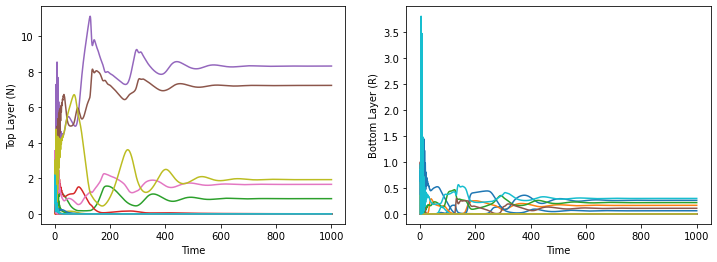

In [177]:
# Example usage
top_species = 30
resources = 50
C_mean = 30
C_std_dev = 1
rho = 0.8
migration = 1e-9

# Generate model parameters
C, E, u, k = generate_model_params(top_species, resources, C_mean, C_std_dev, rho)

# Define simulation parameters
model_type = 'asymmetric_consumer_resource'
t_span = [0, 1000]
initial_state = np.random.rand(top_species + resources)

# Run simulation
sol = ODE_simulator(model_type, t_span, initial_state, top_species, resources, C, E, u, k, migration)
plot_simulation_results(N_values, R_values, sol, top_species, resources, plot_optimization=False, yscale='linear')




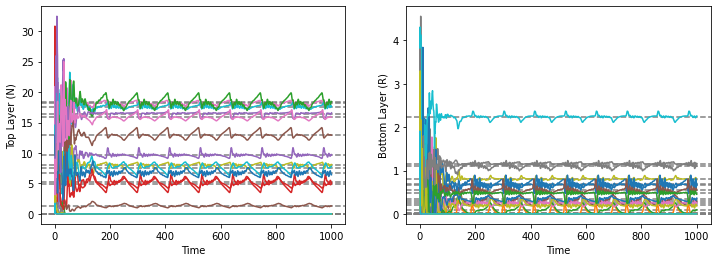

In [160]:

N_values, R_values = find_steady_state(k, C, E, u,  max_iteration=1000, alpha=rho**2, tol=1e-5 )
plot_simulation_results(N_values, R_values, sol, top_species, resources, yscale='linear')


In [179]:
# Assuming the asymmetric_consumer_resource function and generate_model_params function are already defined

def calculate_optimization_difference(model_params, migration=1e-7, simulation_time=500, num_simulations=100):
    differences = []

    for _ in range(num_simulations):
        C, E, u, k = generate_model_params(**model_params)
        top_species, resources = model_params['top_species'] , model_params['resources']
    
        initial_state = np.random.uniform(0, 1, top_species + resources)
        
        ode_function = lambda t, state: asymmetric_consumer_resource(t, state, top_species, C, u, migration, E, k)
        
        sol = solve_ivp( ode_function, t_span=[0, simulation_time], y0=initial_state.copy(),
                        dense_output=True, method='LSODA', atol=1e-10, rtol=1e-10)

        N_values, R_values = find_steady_state(k, C, E, u)

        # Calculate the time-averaged state
        time_avg_N = np.mean(sol.y[:top_species], axis=1)
        time_avg_R = np.mean(sol.y[top_species:], axis=1)

        # Calculate square differences
        diff_N = N_values - time_avg_N
        diff_R = R_values - time_avg_R

        differences.append((diff_N, diff_R))

    return differences

# Example usage:
#(top_species, resources, C_mean, C_std_dev, rho)
model_params = { 'top_species':10, 'resources':20, 'C_mean': 5, 'C_std_dev': 1, 'rho': 0.8 }
differences = calculate_optimization_difference(model_params, simulation_time=500, num_simulations=10)

# Now 'differences' is a list of tuples where each tuple contains the square differences for a simulation.

Delta =  0.687081237183623 Maximum iterations exceeded. Optimization failed. Returned inaccurate result
Delta =  2.860624831012027 Maximum iterations exceeded. Optimization failed. Returned inaccurate result
Delta =  0.8905609487630386 Maximum iterations exceeded. Optimization failed. Returned inaccurate result


In [180]:
differences

[(array([-0.14697823,  1.01609612, -0.04406305, -0.57420394,  0.61563745,
          0.64142941, -0.05387597, -0.88123987, -0.92425179,  0.17104585]),
  array([-0.08152231, -0.07339495, -0.17615101, -0.0164191 , -0.06517728,
          0.0047029 , -0.05576062, -0.01025347, -0.01476648, -0.04417706,
         -0.11792969,  0.11882335, -0.20578845, -0.06931914, -0.05471873,
         -0.08355976, -0.05734919, -0.08817654, -0.05196031, -0.02981253])),
 (array([ 4.49170881e+00, -5.70221387e-03, -1.96510462e+00,  6.80070486e+00,
         -1.19358754e+01, -4.22683418e-01, -3.75292806e-01, -1.26697143e+00,
          6.58018571e+00,  4.63827274e+00]),
  array([-0.07440014, -0.0465957 , -0.19515398, -0.11246353, -0.04357961,
         -0.02773179, -0.04247284, -0.04136873, -0.42466815,  0.21876341,
         -0.02246971, -0.09947751, -0.04332417, -0.05796937, -0.06925807,
         -0.17970018, -0.0101314 ,  0.40269441, -0.04702962, -0.06678322])),
 (array([ 1.66879793, -0.68513152, -0.50827474, -0.15

In [178]:
def calculate_ode_difference(model_params, simulation_time=500, num_simulations=100):
    differences = []

    for _ in range(num_simulations):
        C, E, u, k = generate_model_params(**model_params)
        top_species, resources = model_params['top_species'], model_params['resources']

        initial_state_1 = np.random.uniform(0, 1, top_species + resources)
        initial_state_2 = np.random.uniform(0, 1, top_species + resources)

        ode_function = lambda t, state: asymmetric_consumer_resource(t, state, top_species, C, u, migration, E, k)

        sol_1 = solve_ivp(ode_function, t_span=[0, simulation_time], y0=initial_state_1.copy(),
                          dense_output=True, method='LSODA', atol=1e-10, rtol=1e-10)

        sol_2 = solve_ivp(ode_function, t_span=[0, simulation_time], y0=initial_state_2.copy(),
                          dense_output=True, method='LSODA', atol=1e-10, rtol=1e-10)

        # Calculate the time-averaged states
        time_avg_N_1 = np.mean(sol_1.y[:top_species], axis=1)
        time_avg_R_1 = np.mean(sol_1.y[top_species:], axis=1)

        time_avg_N_2 = np.mean(sol_2.y[:top_species], axis=1)
        time_avg_R_2 = np.mean(sol_2.y[top_species:], axis=1)

        # Calculate square differences between the two simulations
        diff_N = time_avg_N_1 - time_avg_N_2
        diff_R = time_avg_R_1 - time_avg_R_2

        differences.append((diff_N, diff_R))

    return differences